In [137]:
import pandas as pd
import csv
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

![DKB Logo](https://upload.wikimedia.org/wikipedia/commons/d/d4/Deutsche_Kreditbank_AG_Logo_2016.svg)

## Please set these parameters

In [138]:
accountname = '2024' # set filename of the csv. e.g. 

# 0 or less means analyse all months
number_of_last_months_to_analyse = 0 # 4

### Read csv
Works for DKB csv as of 2024-10-31.

In [139]:
csv_file= accountname+".csv"
data = pd.read_csv(csv_file, index_col="Buchungsdatum",
                   header='infer', sep=';', quoting=1,
                   parse_dates=True, date_format="%Y-%m-%d",
                   skiprows = 4, # ignore metadata which doesn't fit CSV rows format
                   keep_default_na=False, # don't make empty values to become NaN
                   encoding='utf-8', dayfirst=True)

In [140]:
# Read metadata
data = data.iloc[::-1] # reverse rows such that bookings are chronologically sorted

with open(csv_file,"r",encoding="utf-8") as f:
    reader = csv.reader(f,delimiter=";")
    metadata = {}
    for i, row in enumerate(reader):
        if "Kontostand" in row[0]:
            value = row[1]
            value = value.replace(".","").replace(",",".")[:-2] # '12.345,67\xa0€' -> '12345.67'
            end_balance = float(value)
            break

start_date = datetime.strptime( data.index[0] ,"%d.%m.%y").date()
end_date = datetime.strptime( data.index[-1] ,"%d.%m.%y").date()

In [141]:

start_date = datetime.strptime( data.index[0] ,"%d.%m.%y").date()
end_date = datetime.strptime( data.index[-1] ,"%d.%m.%y").date()

In [142]:
print("start:",start_date)
print("end:",end_date)
print("end balance:",end_balance)

start: 2024-01-02
end: 2024-12-30
end balance: 2084.74


## Named Columns

In [143]:
party = "Sender => Receiver"
sender = "Zahlungspflichtige*r"
receiver = "Zahlungsempfänger*in"
category = "Kategorie"
amount = "Betrag (€)"
cause = "Verwendungszweck"
balance = "Kontostand (EUR)"

### Cleanup

In [144]:
# Fix US / EU decimal-point/comma
data[amount] = data[amount].str.replace('.','')
data[amount] = data[amount].str.replace(',','.')
data[amount] = data[amount].astype('float')

In [145]:
data.head()

,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz
Buchungsdatum,,,,,,,,,,,
02.01.24,02.01.24,Gebucht,Tom Pfaff,Marco,Malle Anzahlung,Ausgang,DE97292500000001896300,-150.00,,,
02.01.24,02.01.24,Gebucht,Tom Pfaff,Familie Billeriß,Miete,Ausgang,DE89711600000000631280,-730.00,,,
02.01.24,02.01.24,Gebucht,ISSUER,SHELL 0923,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-10.52,,,483364403283640
02.01.24,02.01.24,Gebucht,ISSUER,BackWerk HH Wandsbek S,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-3.40,,,483363303191352
02.01.24,02.01.24,Gebucht,ISSUER,MCDONALDS 01842,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-11.98,,,483364453455729


### Remove small transactions to avoid noise

In [146]:
data = data[abs(data[amount]) > 0.01]

### Inverse Dataframe to have first day first and filter by time-range

In [147]:
from dateutil.relativedelta import relativedelta

if number_of_last_months_to_analyse > 0:
    start_date = end_date - relativedelta(months=number_of_last_months_to_analyse)

# start_date may be not in the index, if there was no booking on that day. in that case, chose the next day which has any booking
if str(start_date) not in data.index:
    for dt_str in data.index:
        dt = datetime.strptime( dt_str ,"%d.%m.%y").date()
        if dt < start_date:
            continue
        start_date = dt
        print("using new start date", start_date, "which is in the index.")
        break

def dt2str(dt):
    return dt.strftime("%d.%m.%y")

print(f"Analysing time range: {start_date} -> {end_date}")
data = data.loc[dt2str(start_date):dt2str(end_date)]

start_and_end_dates_string = "(%i.%i.%i - %i.%i.%i)" % (start_date.day, start_date.month, start_date.year, end_date.day, end_date.month, end_date.year)

using new start date 2024-01-02 which is in the index.
Analysing time range: 2024-01-02 -> 2024-12-30


In [148]:
fr = data.index[0]
to = data.index[-1]
print(fr,"->",to)

02.01.24 -> 30.12.24


### Compute balance at each transaction

In [149]:
data_balance = data[amount].sum().round(2)
start_balance = end_balance - data_balance
data[balance] = data[amount].cumsum()+start_balance

In [178]:
print("start",start_balance)
print("end",end_balance)
print("balance during csv timespan",data_balance)

start 3078.0899999999997
end 2084.74
balance during csv timespan -993.35


## Balance over time

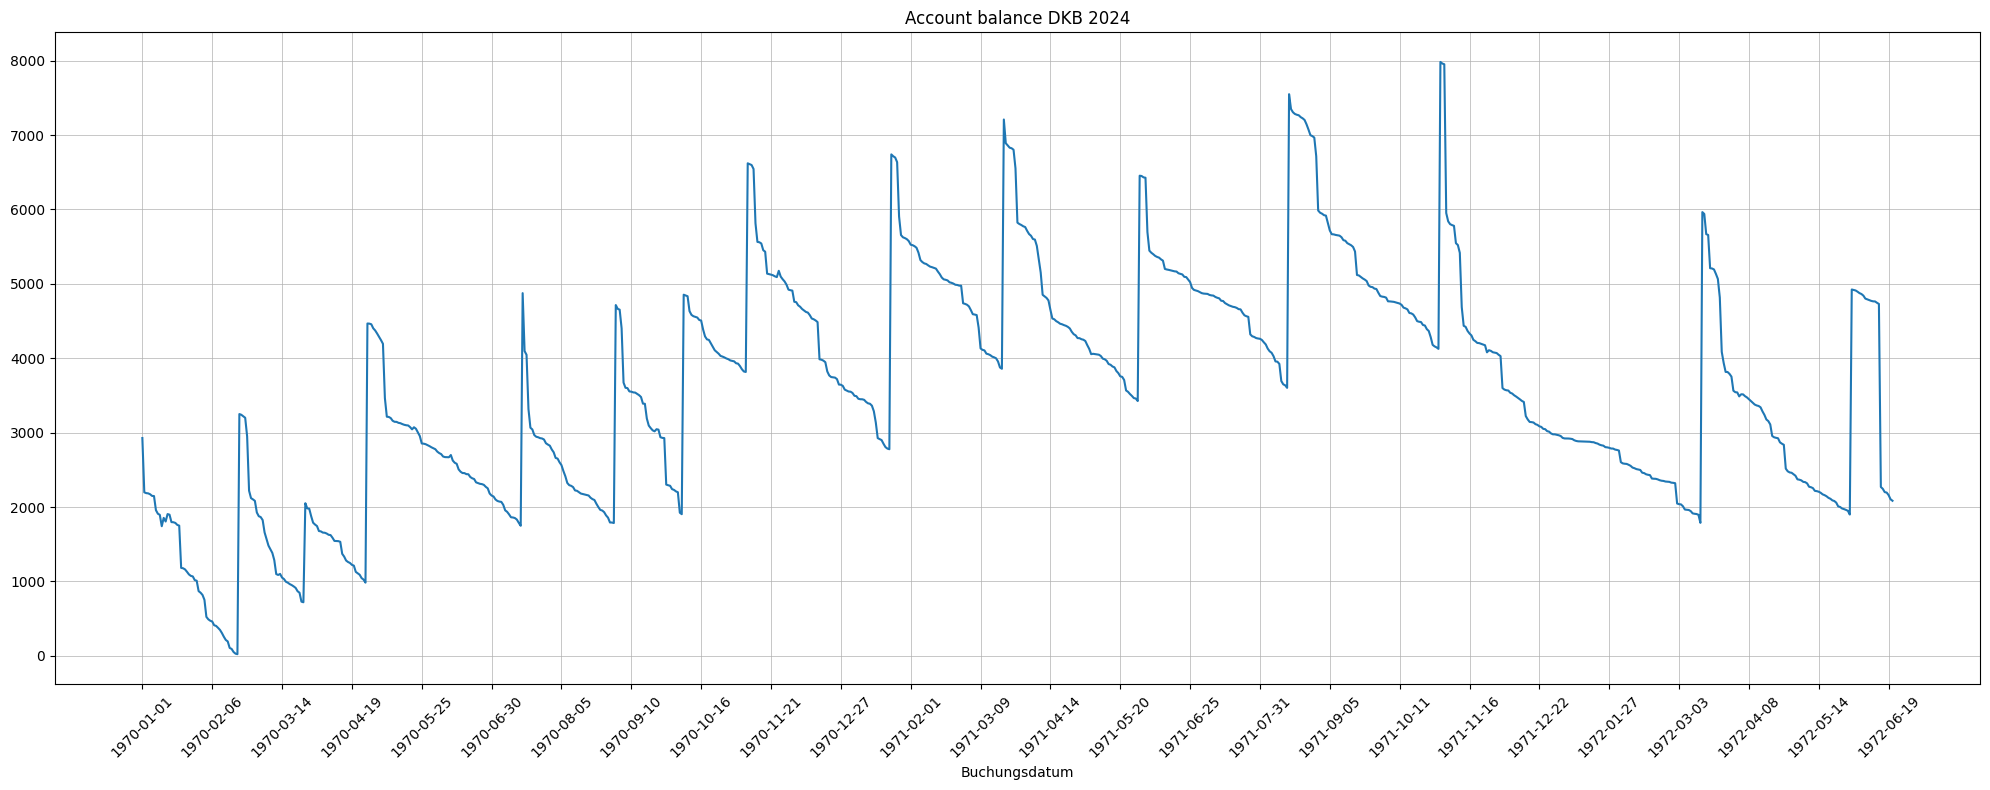

In [ ]:
ax = data[balance].plot(
    title='Account balance DKB %s' % accountname,
    grid=True,
    figsize=(20,8)
);

## Breakdown by transaction party

In [180]:
data[party] = data[sender] + " => " + data[receiver]
tx_party_group = data.groupby(party).agg({amount:"sum"})

In [181]:
tx_party_group = tx_party_group.sort_values(amount, ascending=False)

In [182]:
shortened_party_length = 25

In [183]:
# shorten name
tx_party_group.index = [ "=>".join(map(lambda s: s[:shortened_party_length],str(idx).split("=>"))) for idx in tx_party_group.index ]

In [184]:
tx_party_group[amount].head()

OHB System AG            => Tom Pfaff                   41046.31
STOK F. FINANZAMT MUENCHE=> PFAFF TOM                    2950.00
PayPal Europe S.a.r.l. et=> Tom Pfaff                    1421.22
Markus und Bettina Pfaff => Tom Pfaff                     242.00
ISSUER => EDEKA.M.TRIFTSTR.864/MUE                         -0.59
Name: Betrag (€), dtype: float64

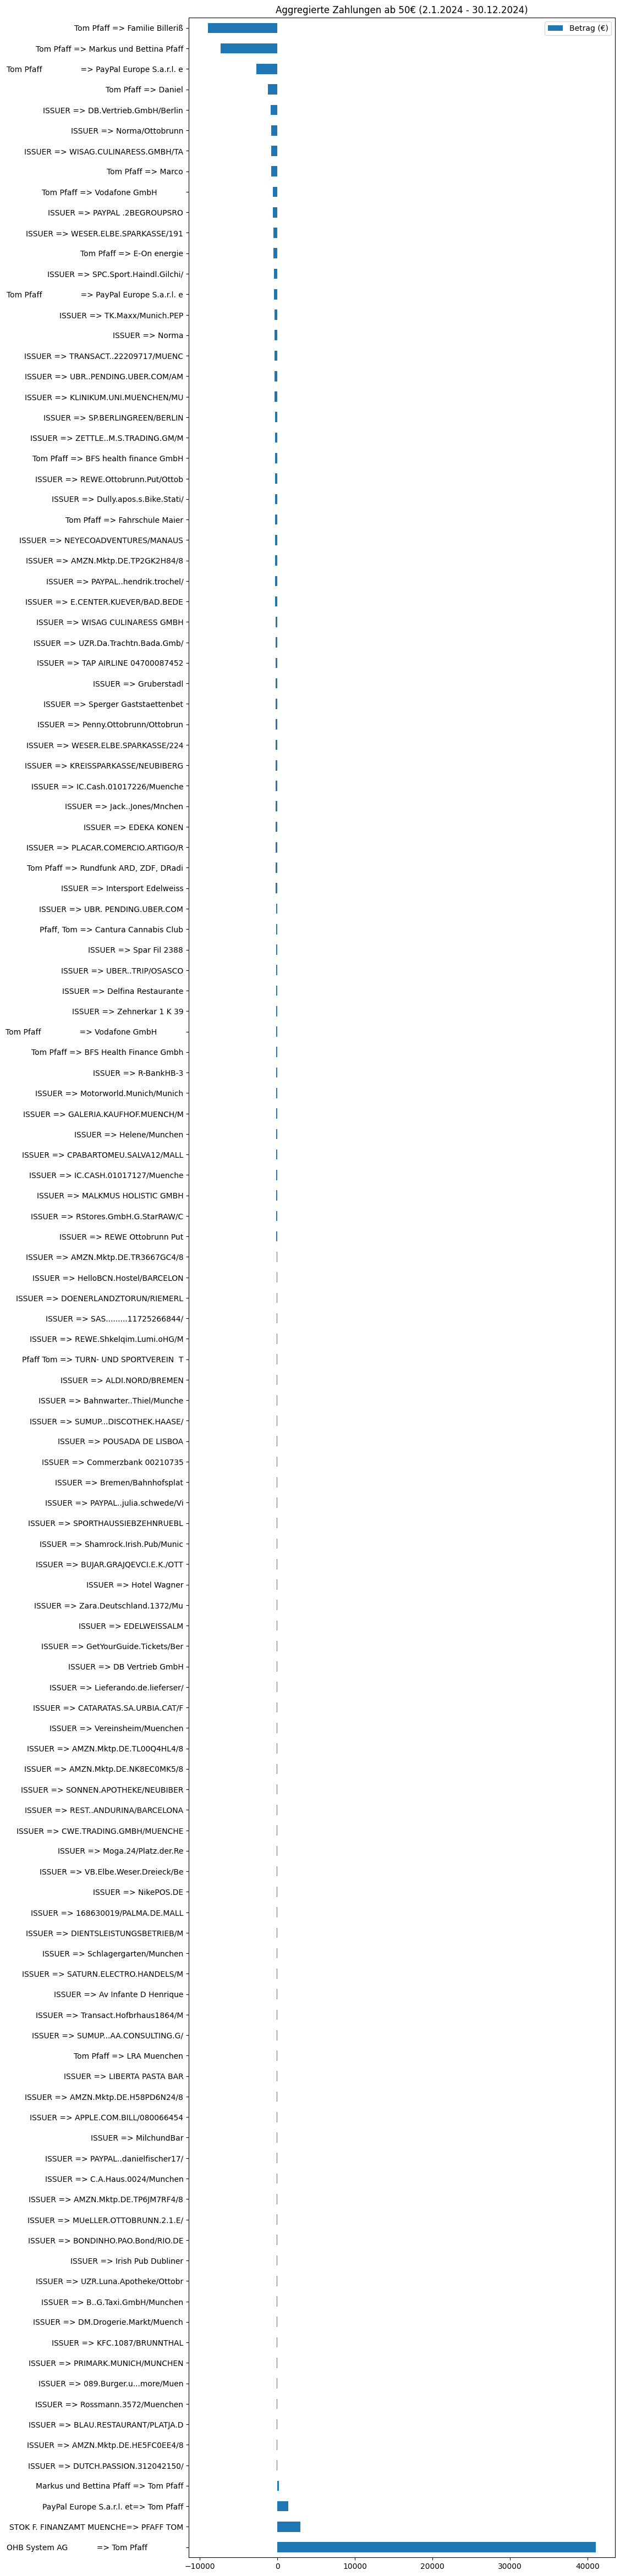

In [185]:
tx_party_group[tx_party_group[amount].abs() > 50].plot.barh(
    figsize=(10,60),
    title=u'Aggregierte Zahlungen ab 50€ %s' % start_and_end_dates_string
  );

In [186]:
data.head()

,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Kontostand (EUR),Sender => Receiver,Kategorie
Buchungsdatum,,,,,,,,,,,,,,
02.01.24,02.01.24,Gebucht,Tom Pfaff,Marco,Malle Anzahlung,Ausgang,DE97292500000001896300,-150.00,,,,2928.09,Tom Pfaff => Marco,tom pfaff => marco
02.01.24,02.01.24,Gebucht,Tom Pfaff,Familie Billeriß,Miete,Ausgang,DE89711600000000631280,-730.00,,,,2198.09,Tom Pfaff => Familie Billeriß,tom pfaff => familie billeriß
02.01.24,02.01.24,Gebucht,ISSUER,SHELL 0923,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-10.52,,,483364403283640,2187.57,ISSUER => SHELL 0923,issuer => shell 0923
02.01.24,02.01.24,Gebucht,ISSUER,BackWerk HH Wandsbek S,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-3.40,,,483363303191352,2184.17,ISSUER => BackWerk HH Wandsbek S,issuer => backwerk hh wandsbek s
02.01.24,02.01.24,Gebucht,ISSUER,MCDONALDS 01842,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-11.98,,,483364453455729,2172.19,ISSUER => MCDONALDS 01842,issuer => mcdonalds 01842


## Breakdown by Category
We use some heuristics on the tranasaction details to put them into different categories.
All transactions within a category will be aggregated for a better overall analysis.
You may need to check the print output of the next cell and possibly adapt the mapping function for a better categorisation.

**the text will be lower cased before categorisation**

**Feel free to change these heuristic mappings - or adapt the code to map according to specififc transaction details.**

In [187]:
categories = {
    "eat_out_or_get_food": [
        "restaurant",
        "gastro",
        "dean david",
        "cafe",
        "baeckerei",
        "coffee fellows",
        "jim block",
        "don qui",
        "Osteria",
        "subway",
        "backhaus",
        "burger king",
        "campus suite",
        "juice.more",
        "Backerei",
        "Avni Terhani",
        "vegan",
        "thai",
        "indisch",
    ],
    "alltag_laden": [
        "lidl",
        "aldi",
        "edeka",
        "alnatura",
        "rewe",
        "vollcorner",
    ],
    "spezial_laden": [
        "karstadt",
        "galeria",
        "kaufhof",
        "mueller",
        "migros",
        "coop",
        "dm fil",
        "go asia",
        "Drogerie",
        "SUCKFUELL",
        "butlers",
        "Suckfull",
        "Bio-Market",
        "conrad m",
    ],
    "online_handel":[
        "otto",
        "conrad elec",
        "amzn mktp",
        "amazon",
    ],
    "transport": [
        "FERNVERKEHR",
        "flixbus",
        "PAYPAL .DBVERTR",
    ],
    "ausflug": [
        "hamburg",
        "Hotel",
        "PAYPAL .booking",
        "prague",
        "praha",
        "Tubingen",
    ],
    "project": [
        "openai",
        "google.cloud",
        "github",
    ],
    "freizeit": [
        "VOLKSBAD",
        "PAYPAL .SENNHEISER",
    ],
    "entertainment": [
        "magellan",
        "Amazon Prime",
        "paypal .steam",
        "netflix"
    ],
    "crypto": [
        "bitflyer",
        "coinbase"
    ],
    "health": [
        "apotheke",
        "Krankenversicherung",
    ],
    "cash": [
        "bargeld",
        "automat",
        "cash"
    ],
    "dkb": [
        "DKB",
        "KREDITBANK",
    ],
    "miete": [],
    "investment": [],
    "emergency_fund":[],
    "uncategorized": [
        "PayPal (Europe)",
    ],
    "card_payment": [],
    "minor": [ # populated automatically
    ]
}

def mapToCategory(x):
    # use these transaction details to map to a category
    p = x[party].lower()
    c = x[cause].lower()
    
    # manual mappings
    if "WERTP. ABRECHN".lower() in c or "Depot ".lower() in c or "WERTPAPIER".lower() in c:
        return "investment"
    
    if "miete ".lower() in c:
        return "miete"
    
    if "KREDITKARTENABRECHNUNG".lower() in c:
        return "card_payment"
    
    # mappings by category
    for cat, cat_words in categories.items():
        if any(map(lambda r: r.lower() in p, cat_words)):
            return cat
    
    # debitcard. may need adaptation
    if "Debitk.20 VISA Debit".lower() in c:
        return "card_payment"
    
    return p

data[category] = data.apply(lambda x: mapToCategory(x), axis=1)

print(len(data[category].unique()),"categories")

print("============ uncategorized =================")
s = 0
for x in data[category].unique():
    ok = False
    
    for cat in categories.keys():
        if x == cat:
            ok = True

    if not ok:
        print(x)
        idx = data[category] == x
        s = s + abs(data[idx][amount].sum())
        
print("================================ sum of uncategorized: ",s) # todo. this doesn't seem to make sense ... 🤔

362 categories
============ uncategorized =================
tom pfaff => marco
tom pfaff => familie billeriß
issuer => shell 0923
issuer => backwerk hh wandsbek s
issuer => mcdonalds 01842
issuer => parc sandur
issuer => uber .trip
issuer => paypal .janek.woehlke
issuer => mcdonalds 00862
tom pfaff                                                             karl-huber-strase => paypal europe s.a.r.l. et cie s.c.a
markus und bettina pfaff => tom pfaff
issuer => norma
issuer => commerzbank 00210735
issuer => backstube wuensche gmb
issuer => paypal .2begroupsro
tom pfaff => revimed
issuer => wisag culinaress gmbh
issuer => ubr. pending.uber.com
issuer => sperger gaststaettenbet
issuer => milchundbar
issuer => tap airline 04700087452
issuer => et car hire
issuer => do co allianz arena
issuer => doco allianz arena
issuer => irish pub dubliner
issuer => augustiner keller
issuer => 49005809 kiosk hauptstr
tom pfaff => vodafone gmbh                                                         40549

Breakdown by category. (Ignored transactions below 10€).

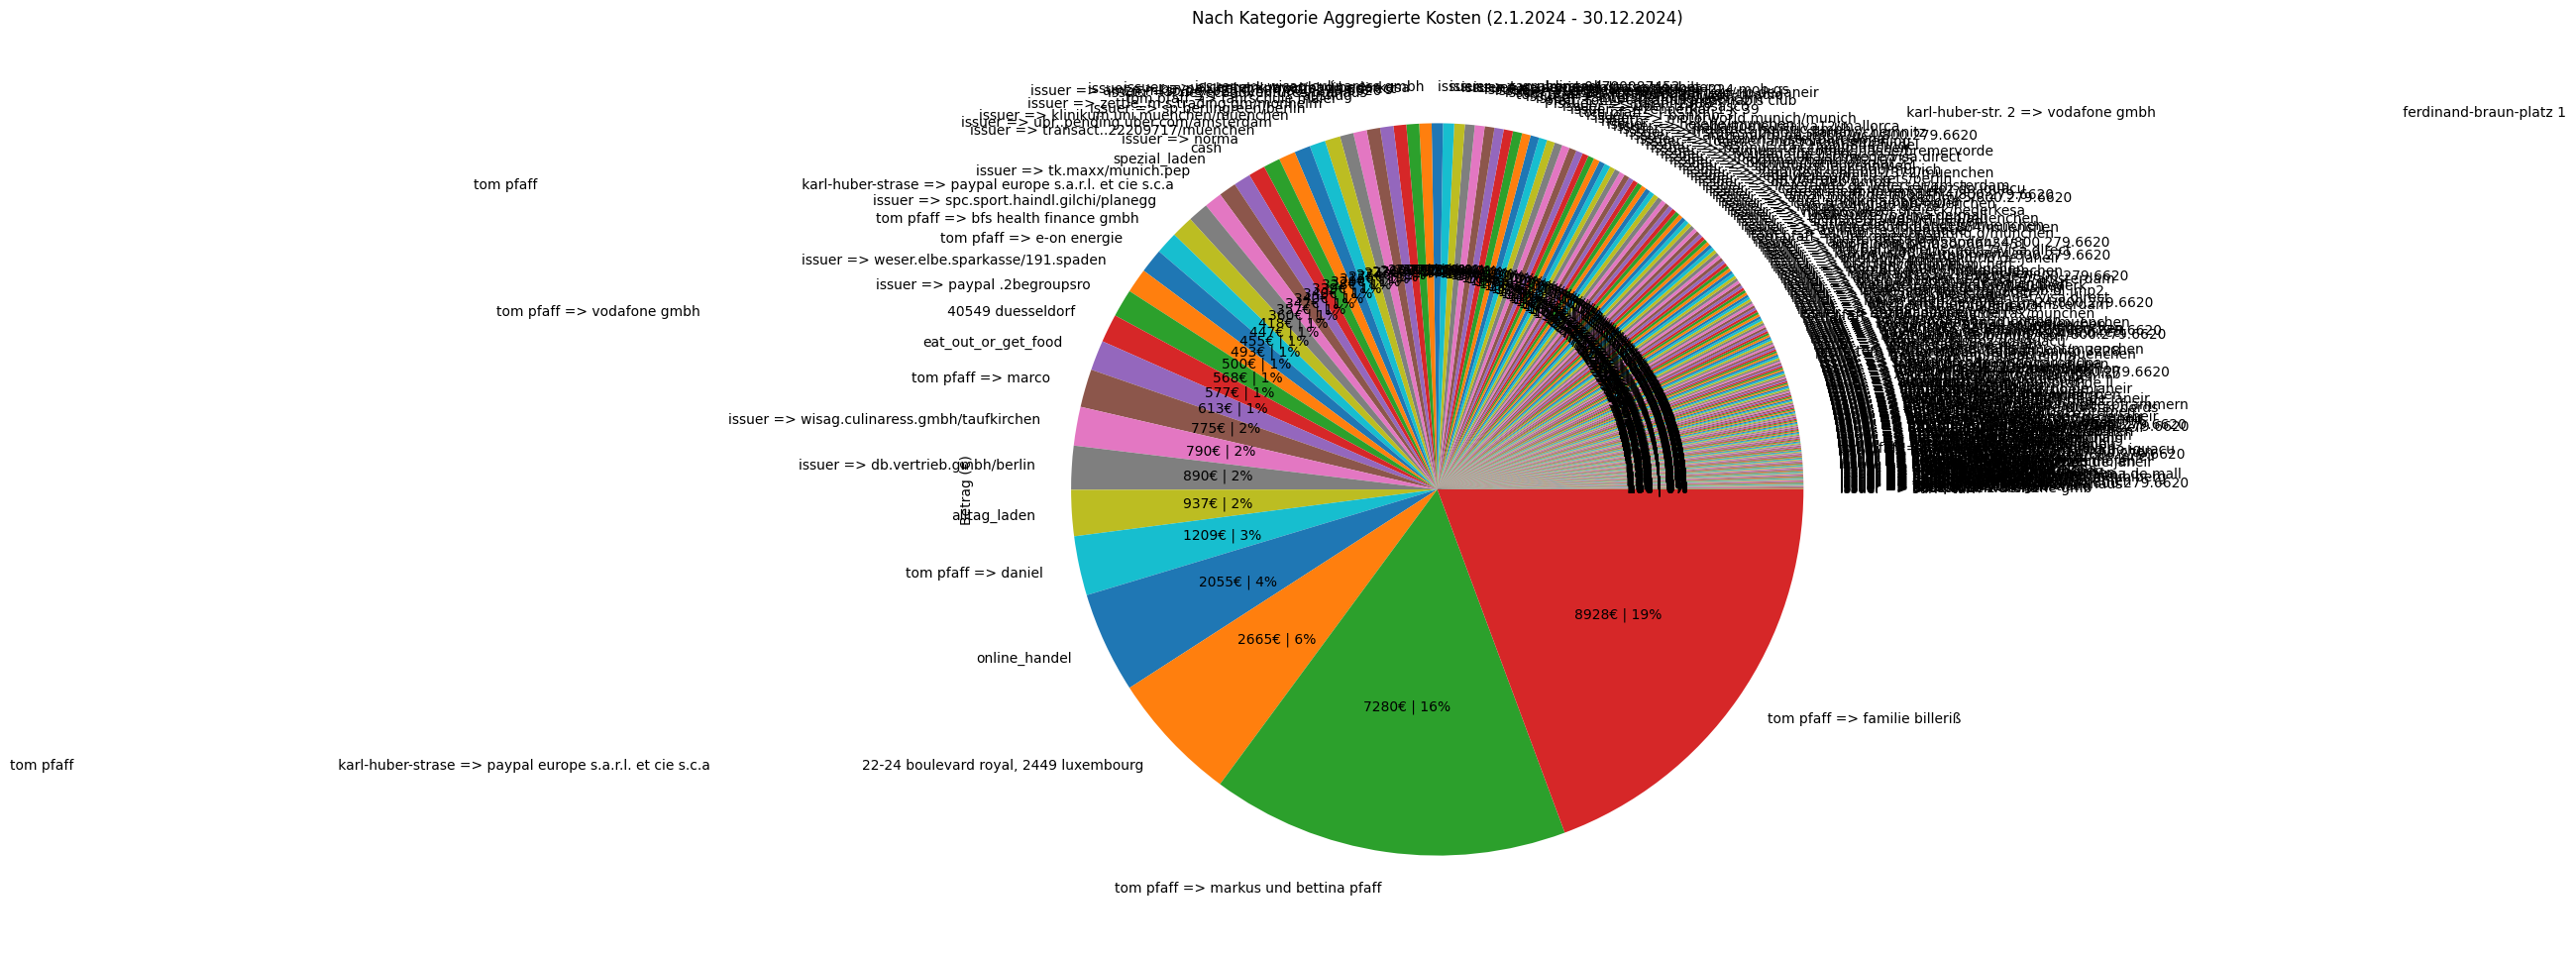

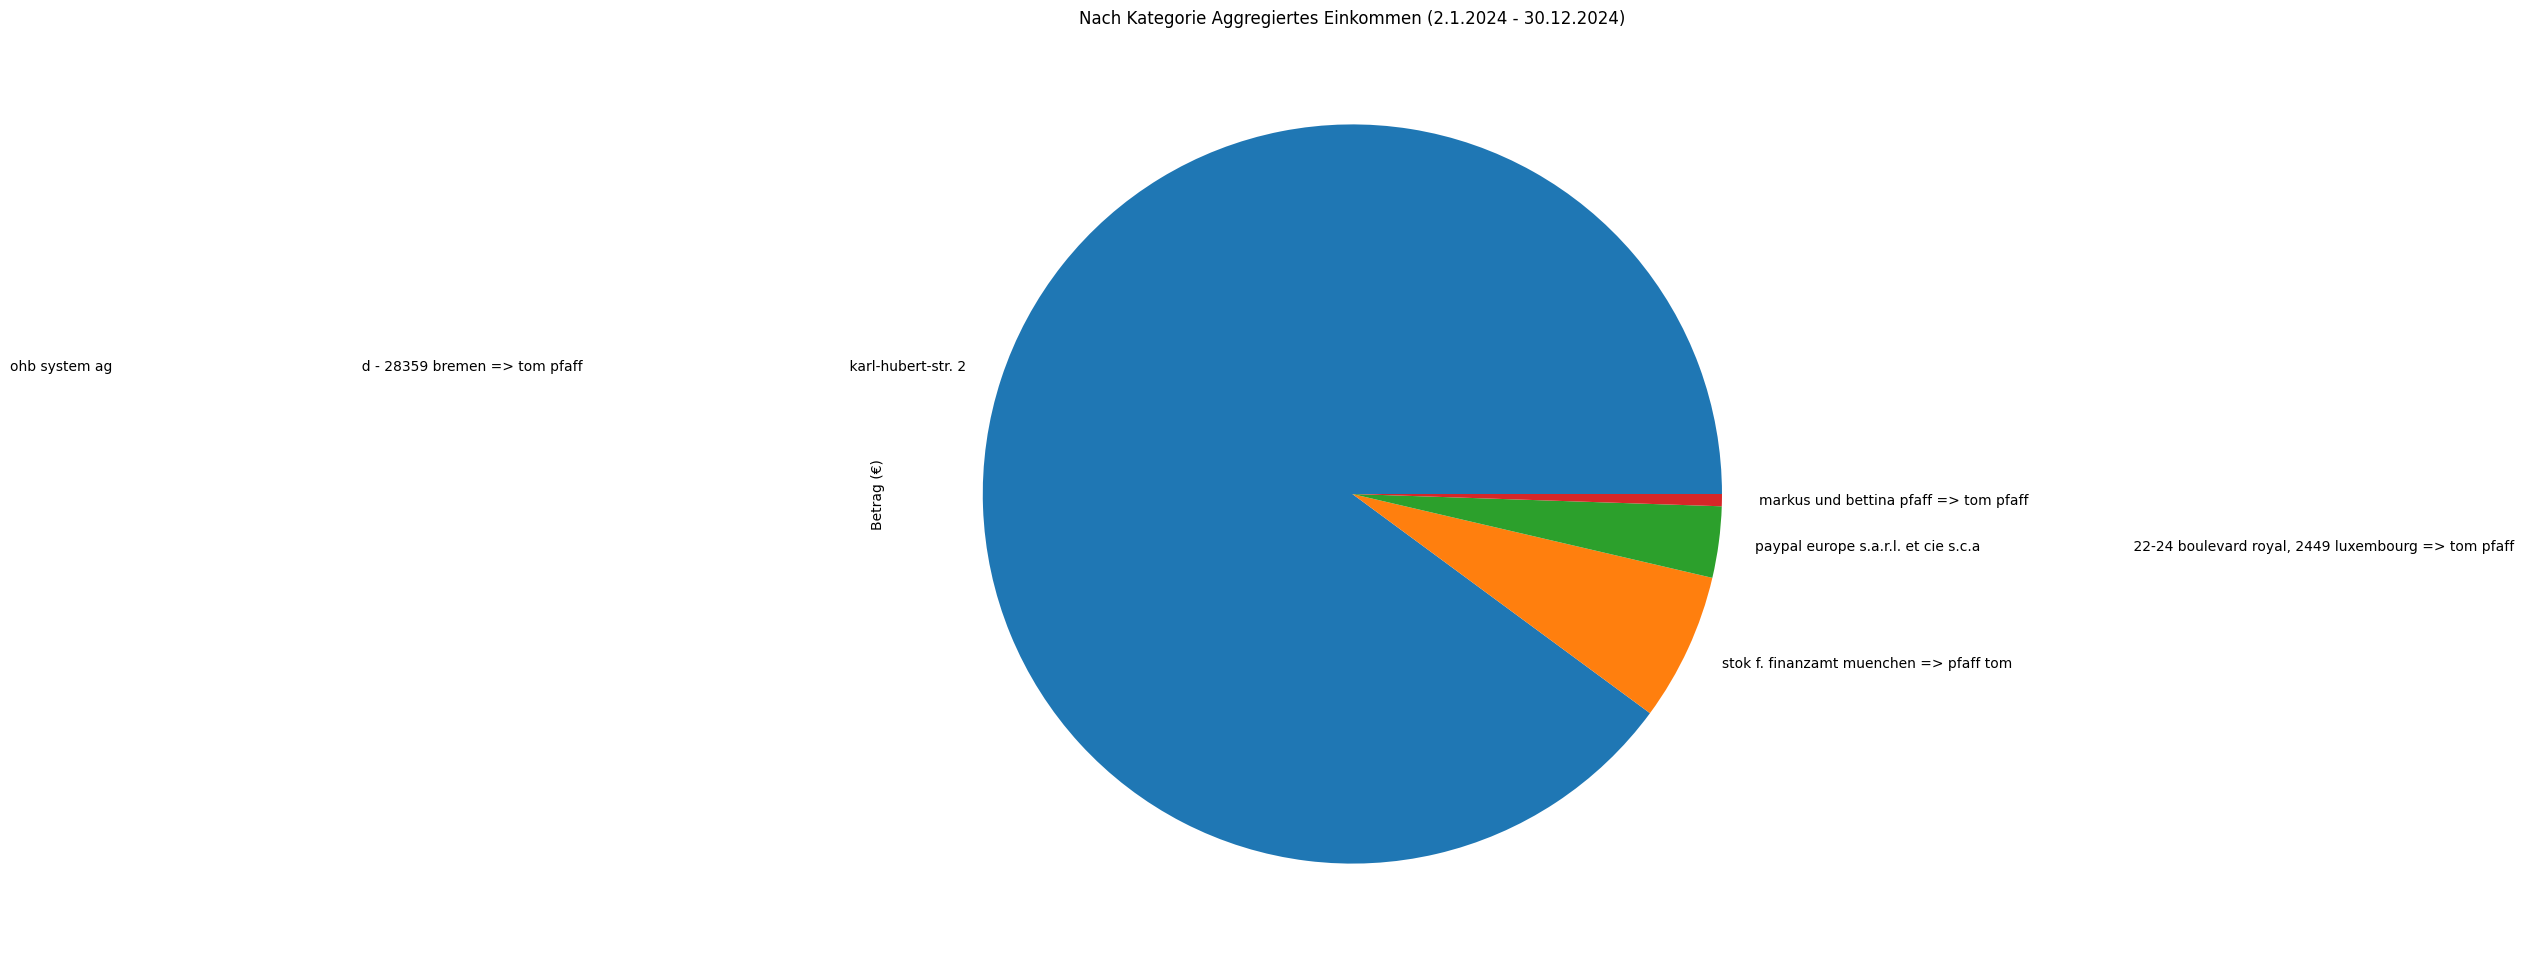

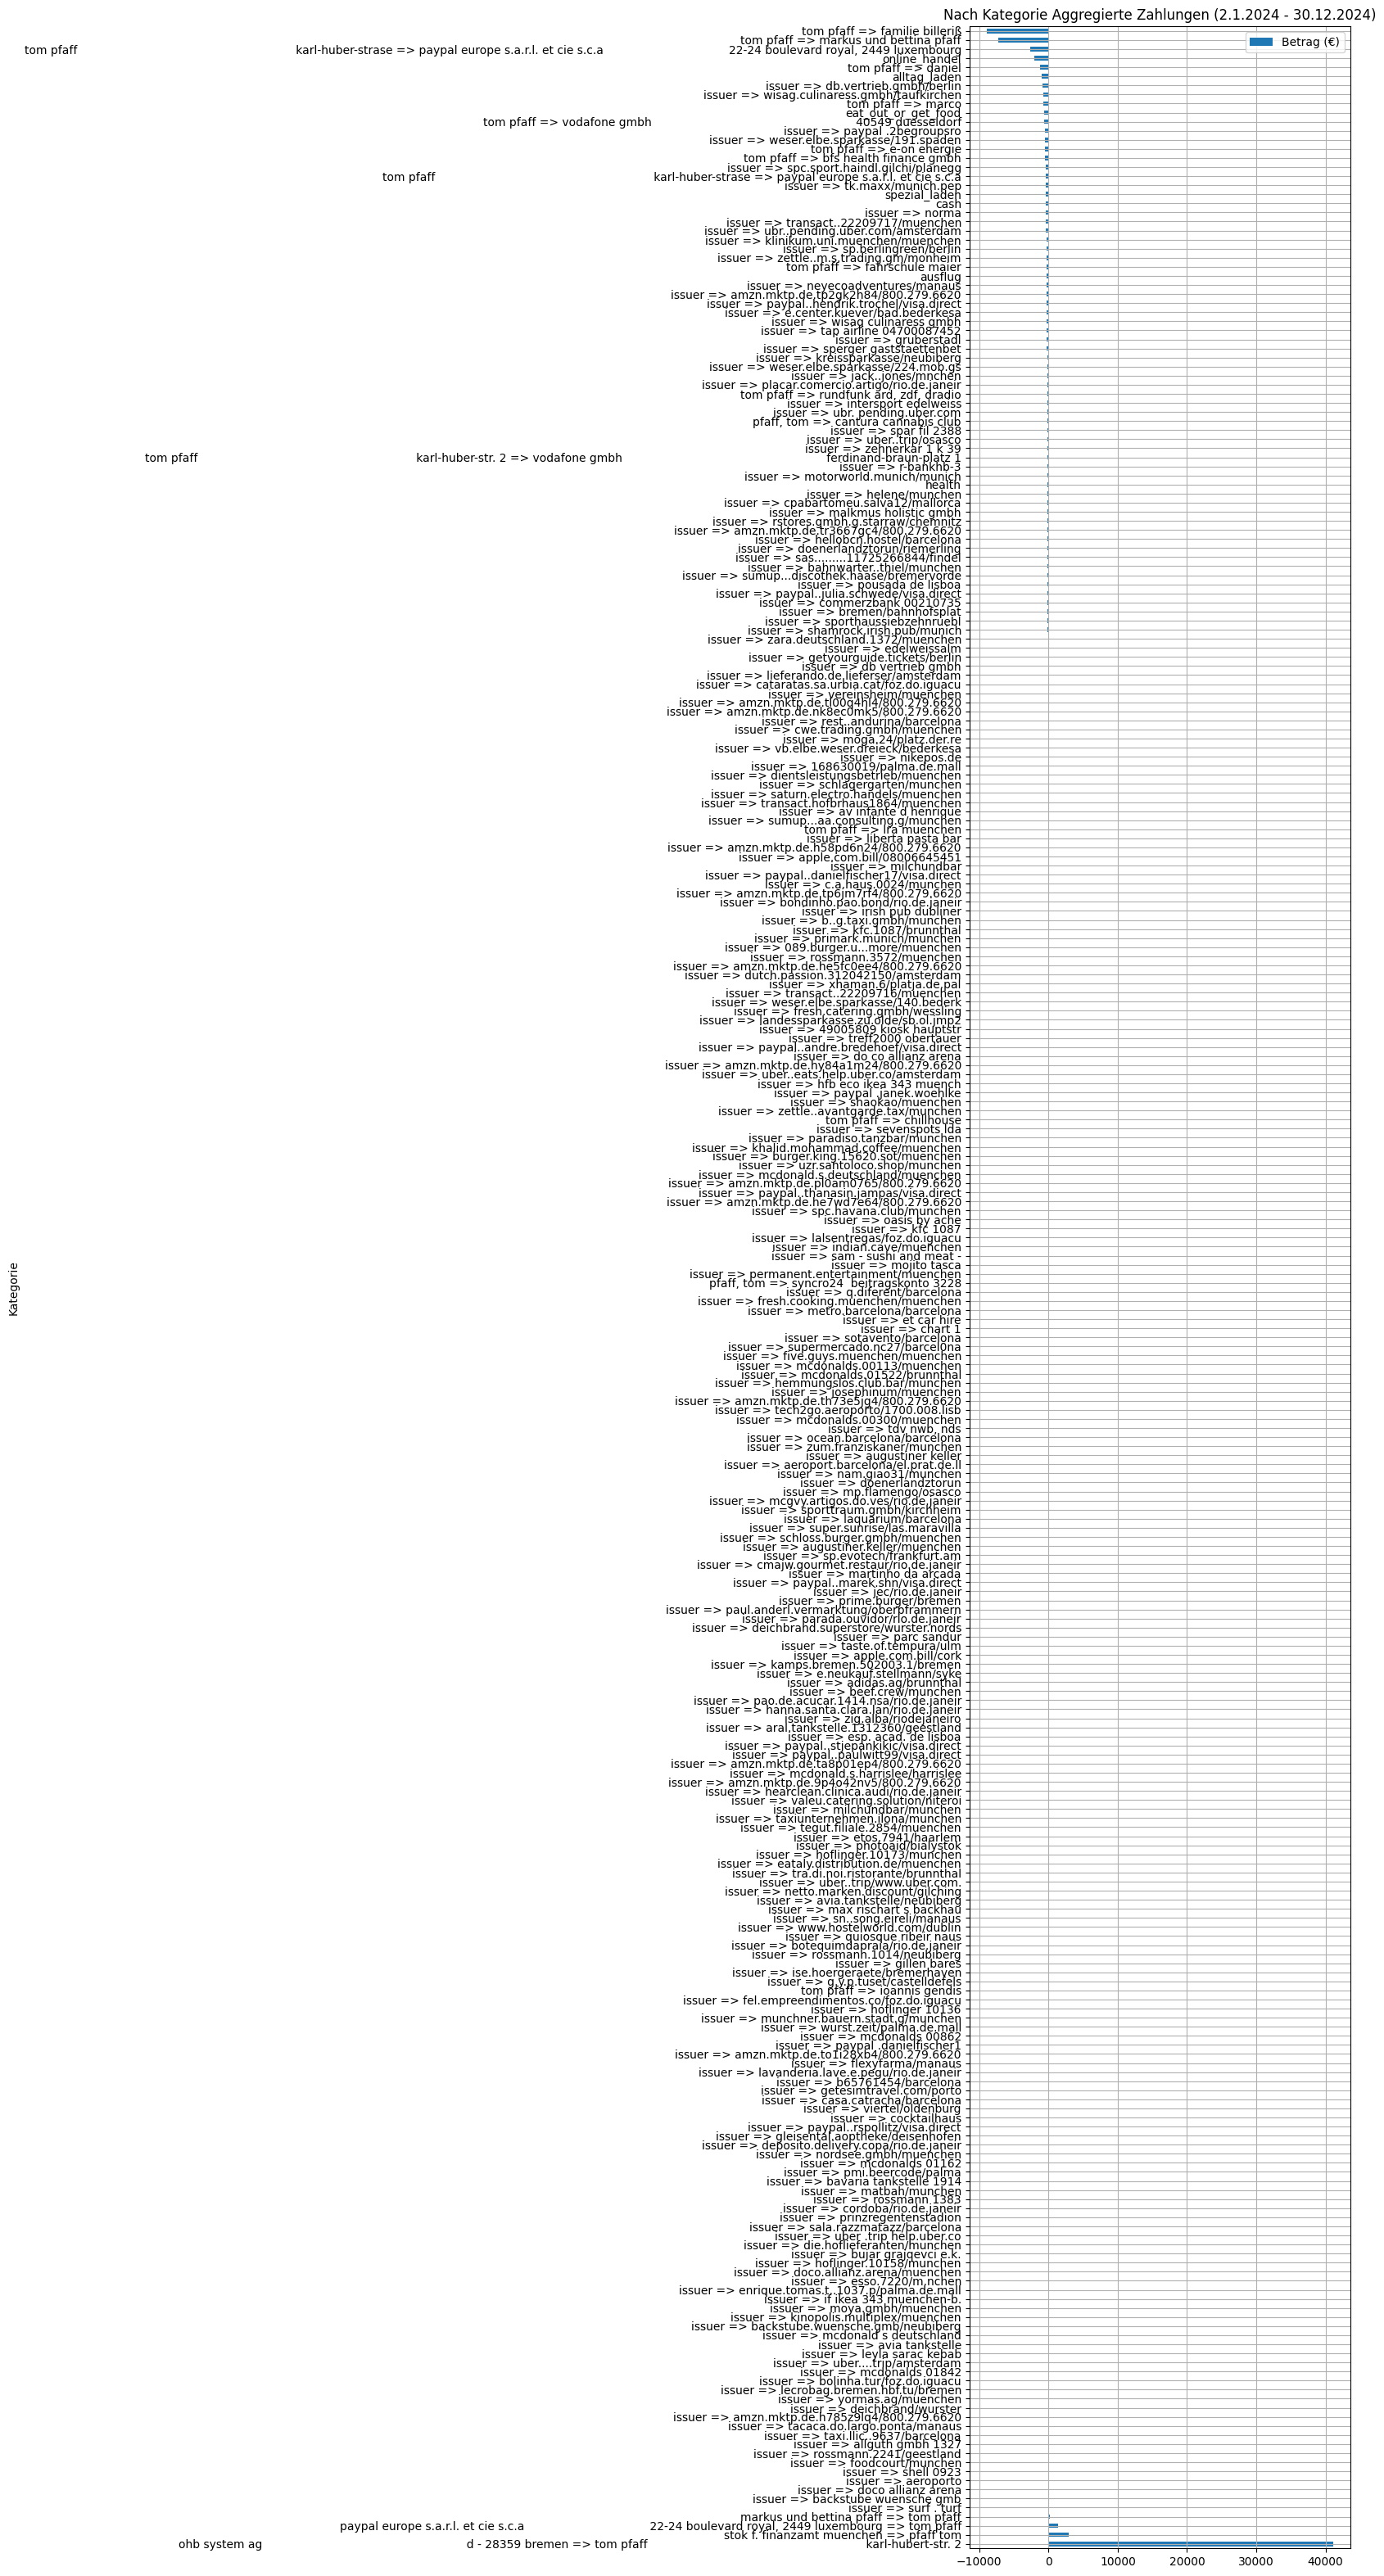

In [188]:
byCategory = data.groupby(category).agg({amount:"sum"}).sort_values(amount,ascending=False)
byCategory = byCategory[abs(byCategory[amount]) > 10]
    

costs = byCategory[byCategory[amount] < 0]
costs.loc[:,amount] = -costs[amount]

total_costs = costs[amount].sum()
costs.plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    autopct=lambda x: str(round(x/100*total_costs)) + "€ | " + str(round(x)) + "%",
    title=u'Nach Kategorie Aggregierte Kosten %s' % start_and_end_dates_string
)
plt.show()

byCategory[byCategory[amount] > 0].plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    title=u'Nach Kategorie Aggregiertes Einkommen %s' % start_and_end_dates_string
)
plt.show()


byCategory.plot.barh(
    figsize=(6,40),
    grid=True,
    title=u'Nach Kategorie Aggregierte Zahlungen %s' % start_and_end_dates_string
)
plt.show()


### Category analysis

In [189]:
def quick_category_analyse(cat,desc=party):
    excursions = data[data[category] == cat].sort_values(amount,ascending=True)

    excursions.plot.barh(
        figsize=(12,12),
        x=desc,
        y=amount,
        legend=None,
    )
    plt.show()

    return excursions

IndexError: index 0 is out of bounds for axis 0 with size 0

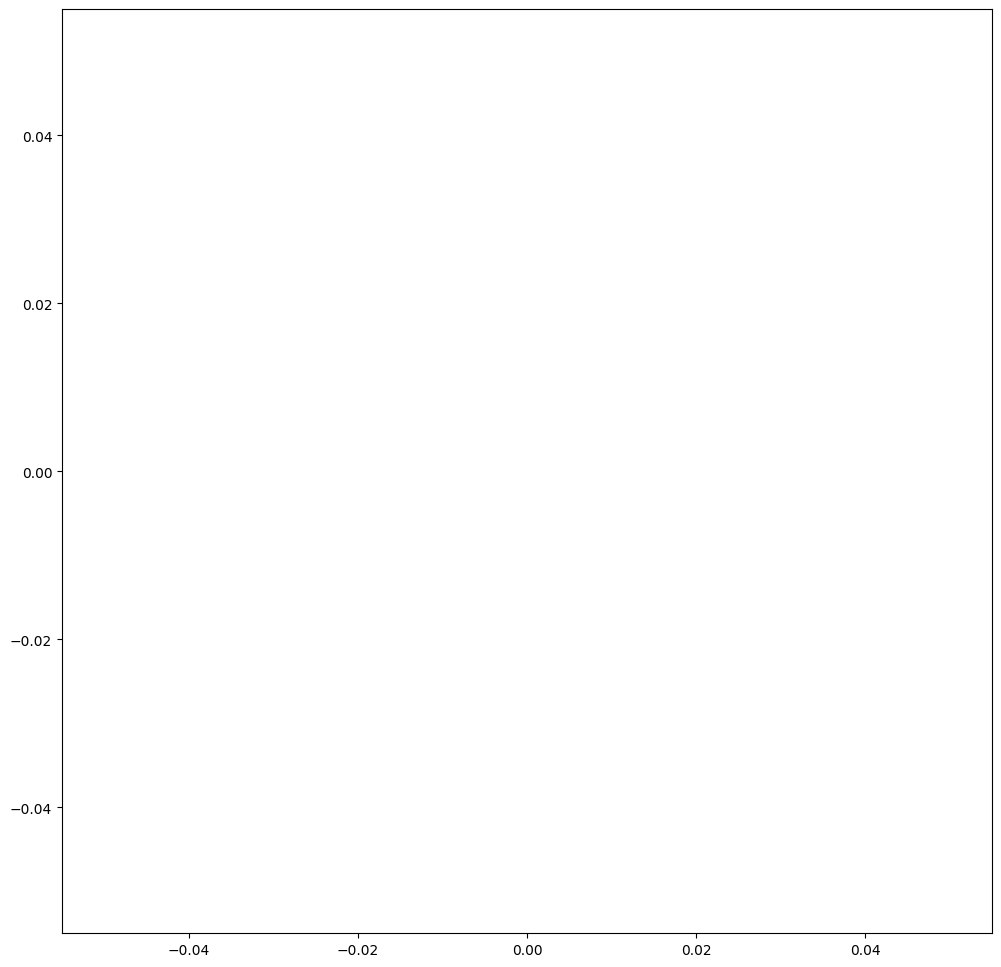

In [190]:
quick_category_analyse("investment",desc=cause)

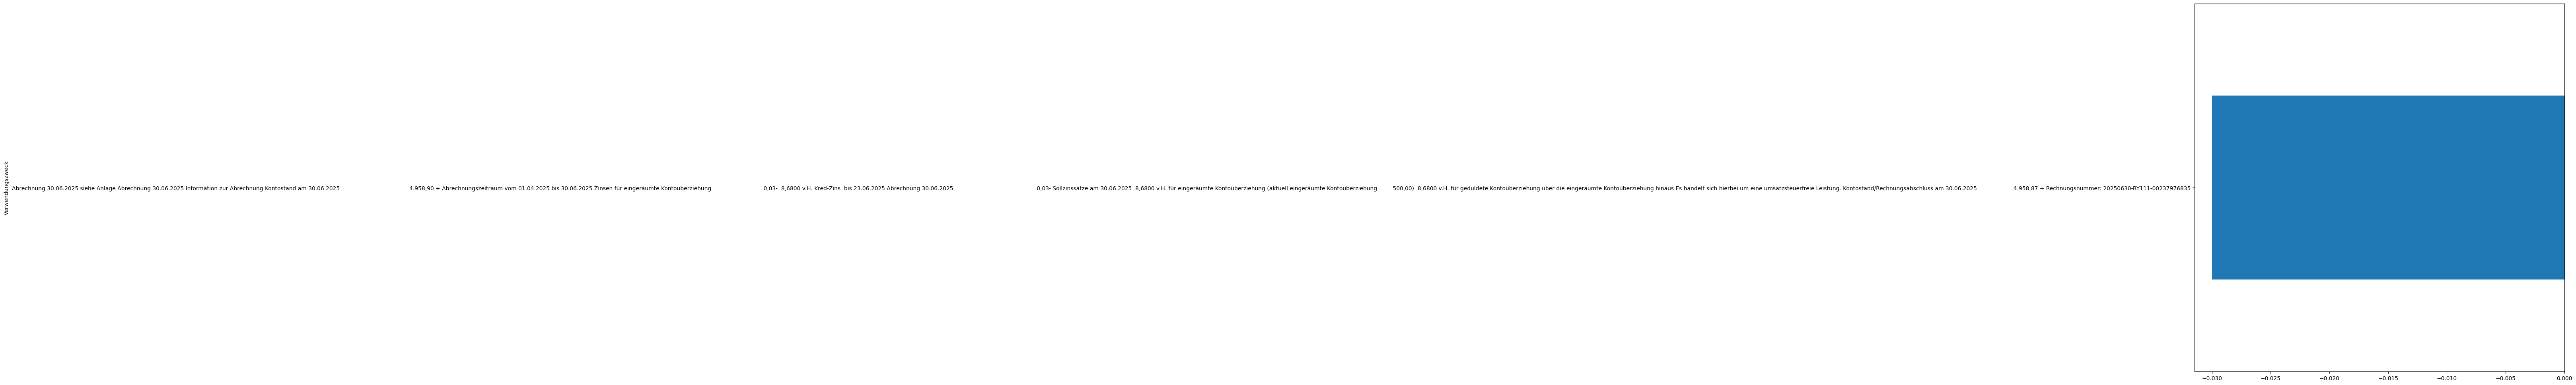

,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Kontostand (EUR),Sender => Receiver,Kategorie
Buchungsdatum,,,,,,,,,,,,,,
01.07.25,01.07.25,Gebucht,DKB AG,DKB AG,Abrechnung 30.06.2025 siehe Anlage Abrechnung ...,Ausgang,0000000000,-0.03,,,,3068.7,DKB AG => DKB AG,dkb


In [ ]:
quick_category_analyse("dkb", desc=cause)

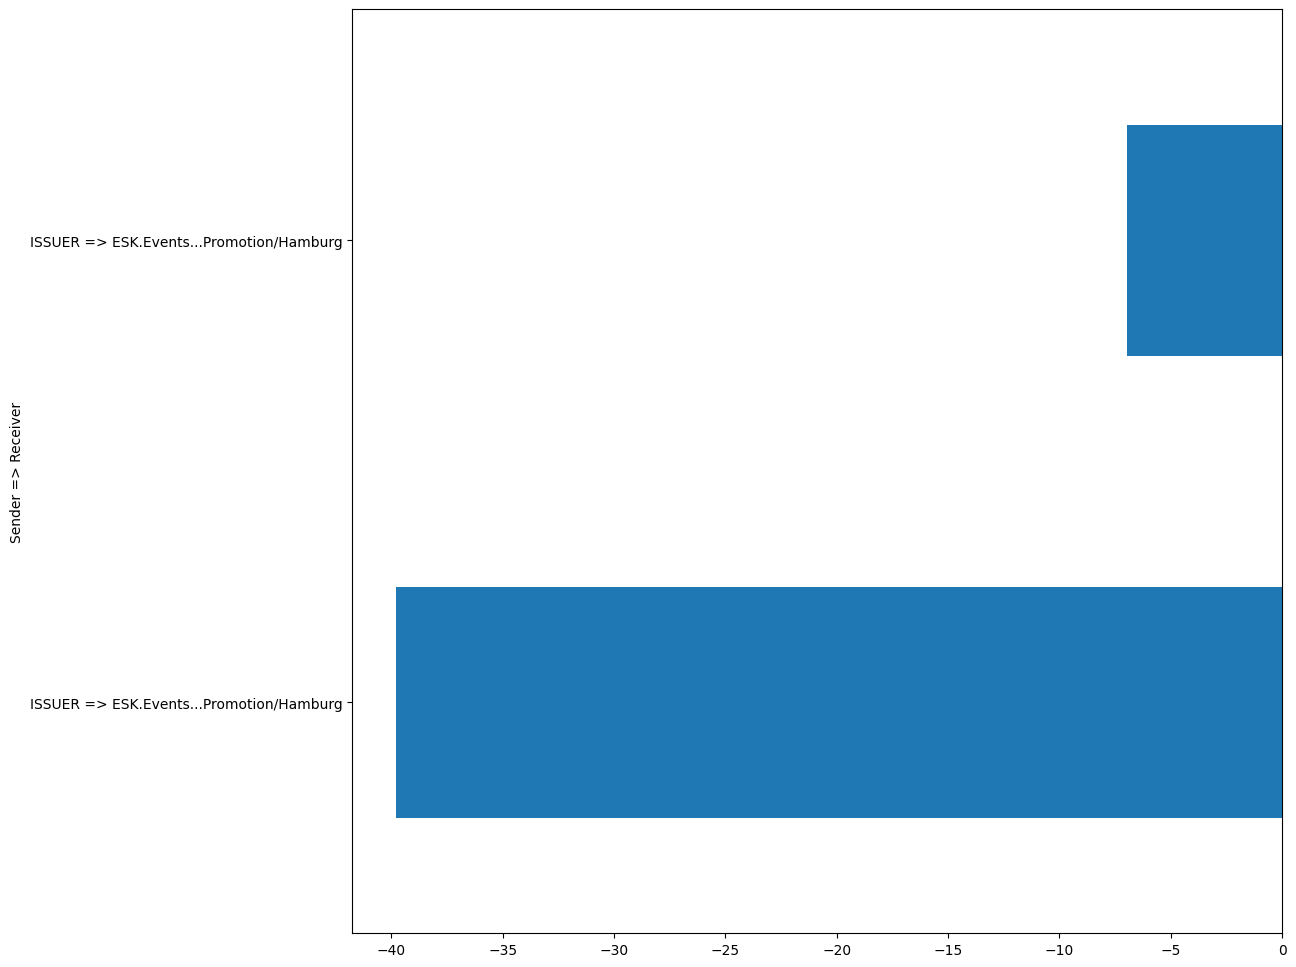

,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Kontostand (EUR),Sender => Receiver,Kategorie
Buchungsdatum,,,,,,,,,,,,,,
18.07.25,18.07.25,Gebucht,ISSUER,ESK.Events...Promotion/Hamburg,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-39.78,,,485198275590325,671.03,ISSUER => ESK.Events...Promotion/Hamburg,ausflug
21.07.25,21.07.25,Gebucht,ISSUER,ESK.Events...Promotion/Hamburg,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-6.95,,,485200271092578,628.58,ISSUER => ESK.Events...Promotion/Hamburg,ausflug


In [ ]:
quick_category_analyse("ausflug")

IndexError: index 0 is out of bounds for axis 0 with size 0

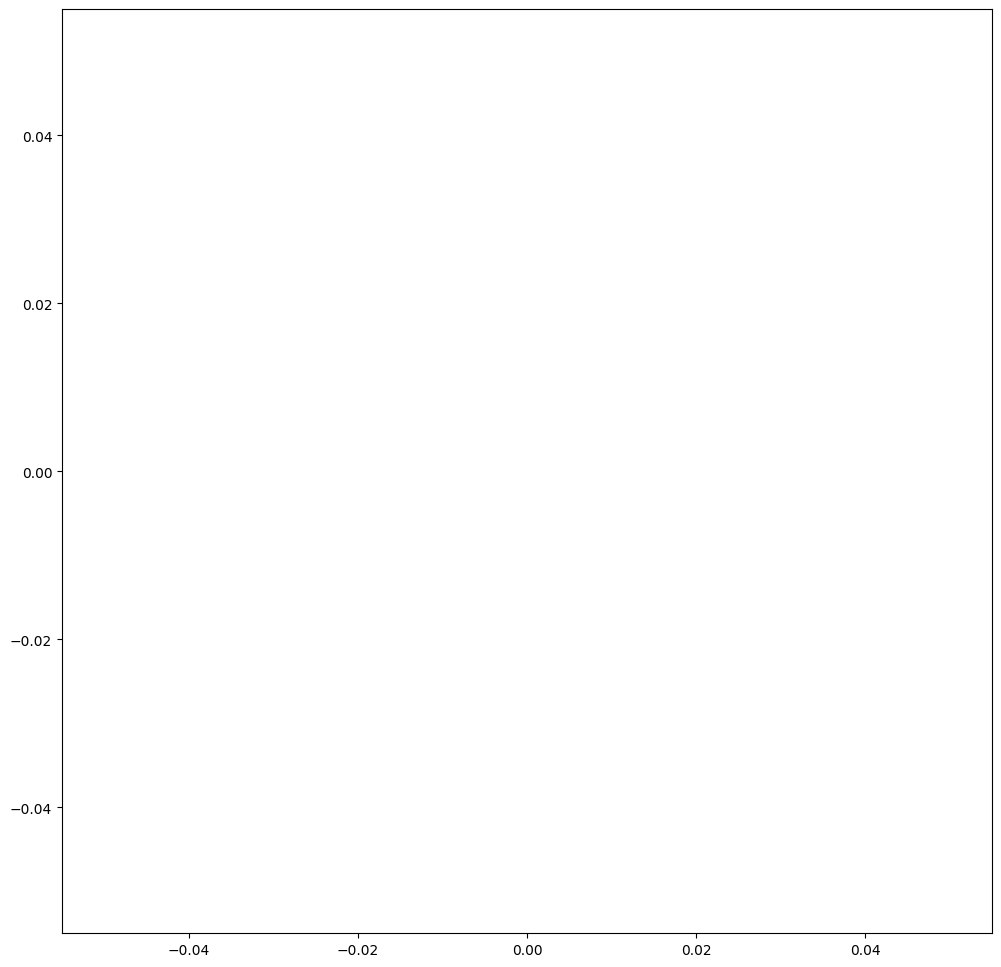

In [ ]:
quick_category_analyse("card_payment")

IndexError: index 0 is out of bounds for axis 0 with size 0

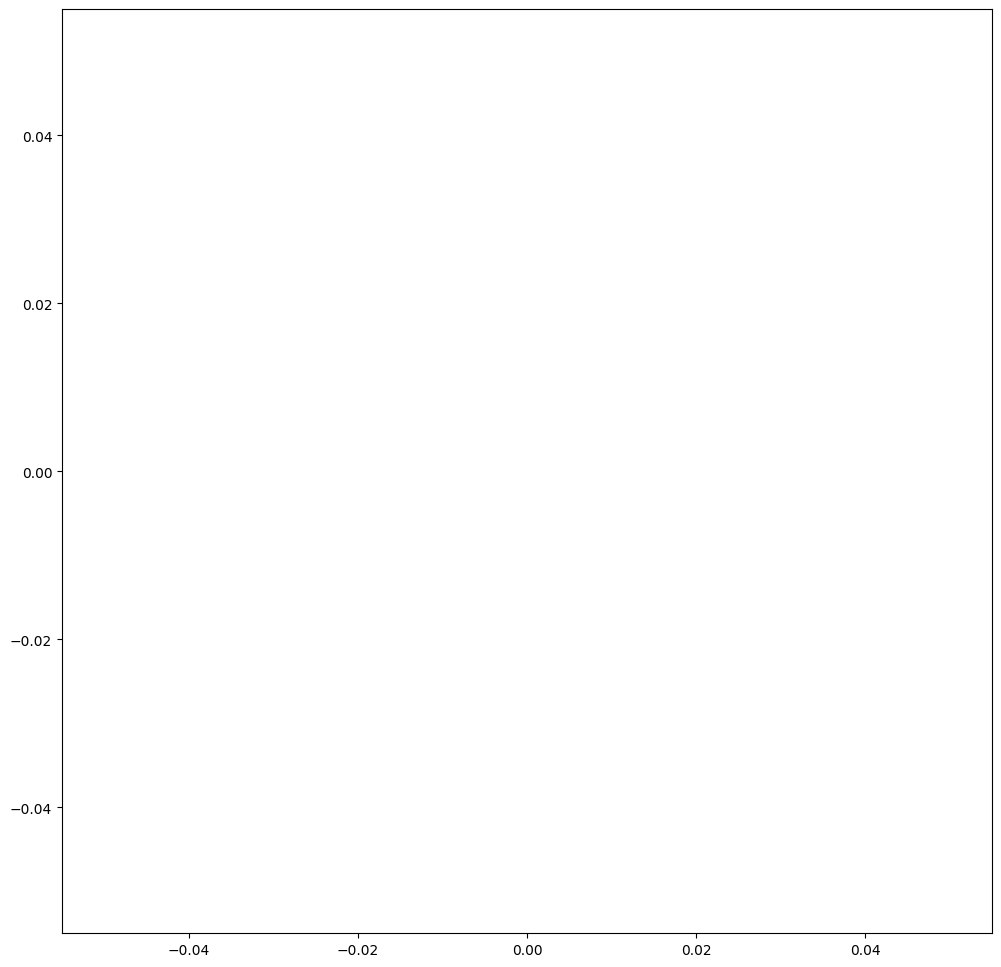

In [ ]:
quick_category_analyse("transport")